In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import (RandomOverSampler, SMOTE, BorderlineSMOTE)
from imblearn.under_sampling import (RandomUnderSampler, NearMiss, TomekLinks)
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix

pd.options.display.float_format = '{:,.3f}'.format
warnings.filterwarnings('ignore')

In [2]:
# read data
data = pd.read_csv('TravelInsurance2.csv', sep=';')
data.head()

,Age,Employment.Type,GraduateOrNot,AnnualIncome,FamilyMembers,ChronicDiseases,FrequentFlyer,EverTravelledAbroad,TravelInsurance
0,33,Private Sector/Self Employed,Yes,750000,7,1,No,No,1
1,29,Private Sector/Self Employed,Yes,1100000,2,0,No,No,0
2,31,Government Sector,Yes,1200000,3,0,No,No,0
3,26,Private Sector/Self Employed,Yes,500000,3,0,No,No,0
4,28,Private Sector/Self Employed,Yes,800000,3,0,No,No,0


In [3]:
mapping = {'Yes': 1,
          'No': 0,}

cols_to_map = ['GraduateOrNot', 'FrequentFlyer', 'EverTravelledAbroad']
for col in cols_to_map:
    data[col] = data[col].map(mapping)

In [4]:
print(f"Liczba danych: {len(data)}")
print(f"Liczba osob, ktore wykupily i nie wykupily ubezpieczenia: \n{data['TravelInsurance'].value_counts()}")

Liczba danych: 1000
Liczba osob, ktore wykupily i nie wykupily ubezpieczenia: 
0    659
1    341
Name: TravelInsurance, dtype: int64


## EDA

In [5]:
travelinsur1 = data[data['TravelInsurance'] == 1]
travelinsur0 = data[data['TravelInsurance'] == 0]

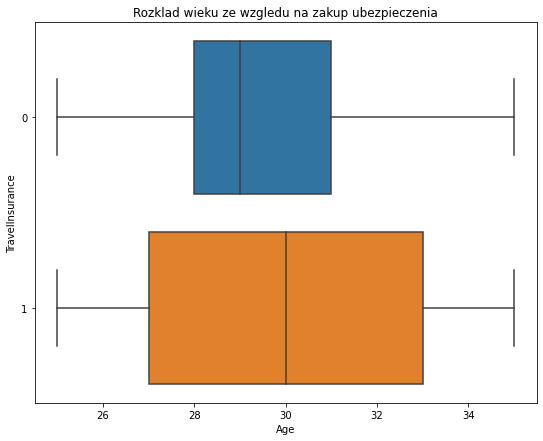

In [6]:
# Age
fig, ax = plt.subplots(figsize=(9,7))
sns.boxplot(data=data, x='Age', y='TravelInsurance', orient='h')
ax.set_title('Rozklad wieku ze wzgledu na zakup ubezpieczenia')
plt.show()

<AxesSubplot:xlabel='TravelInsurance'>

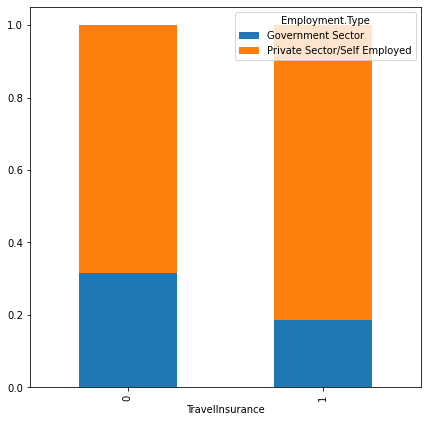

In [7]:
# Employment.Type
(data.groupby('TravelInsurance')['Employment.Type'].value_counts(normalize=True)
   .unstack('Employment.Type').plot.bar(stacked=True, figsize=(7,7))
)

<AxesSubplot:xlabel='TravelInsurance'>

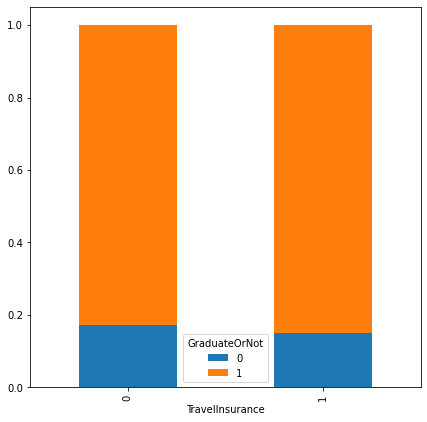

In [8]:
# GraduateOrNot
(data.groupby('TravelInsurance')['GraduateOrNot'].value_counts(normalize=True)
   .unstack('GraduateOrNot').plot.bar(stacked=True, figsize=(7,7))
)

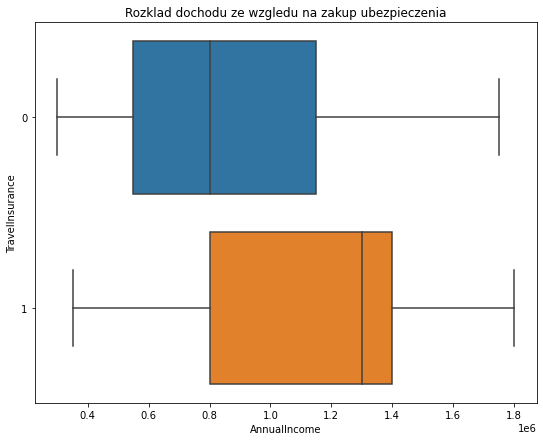

In [9]:
# AnnualIncome
fig, ax = plt.subplots(figsize=(9,7))
sns.boxplot(data=data, x='AnnualIncome', y='TravelInsurance', orient='h')
ax.set_title('Rozklad dochodu ze wzgledu na zakup ubezpieczenia')
plt.show()

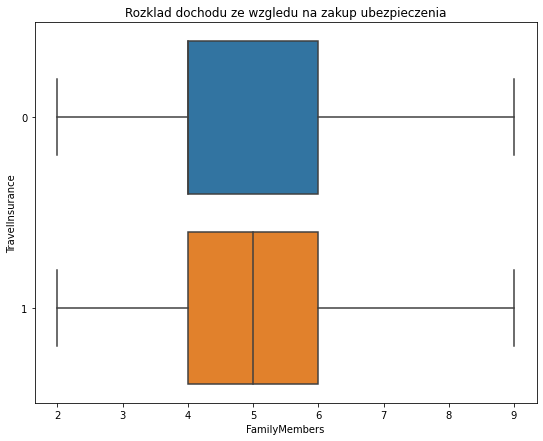

In [10]:
# FamilyMembers
fig, ax = plt.subplots(figsize=(9,7))
sns.boxplot(data=data, x='FamilyMembers', y='TravelInsurance', orient='h')
ax.set_title('Rozklad dochodu ze wzgledu na zakup ubezpieczenia')
plt.show()

In [11]:
fam_members_grouped = data.groupby('TravelInsurance')['FamilyMembers'].value_counts(normalize=True)
fam_members_grouped = fam_members_grouped.reset_index(name='Percentage')

<AxesSubplot:xlabel='FamilyMembers', ylabel='Percentage'>

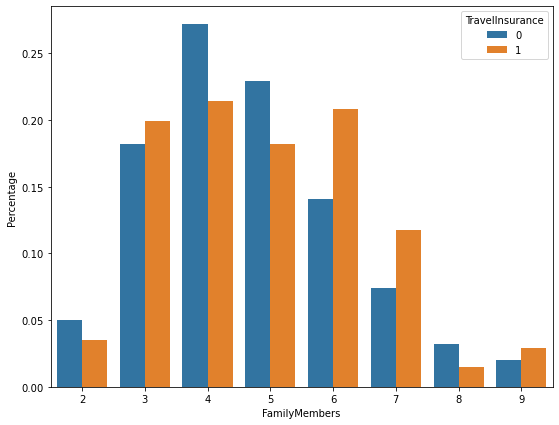

In [12]:
fig, ax = plt.subplots(figsize=(9, 7))
sns.barplot(data=fam_members_grouped, x='FamilyMembers', y='Percentage', hue='TravelInsurance')

<AxesSubplot:xlabel='TravelInsurance'>

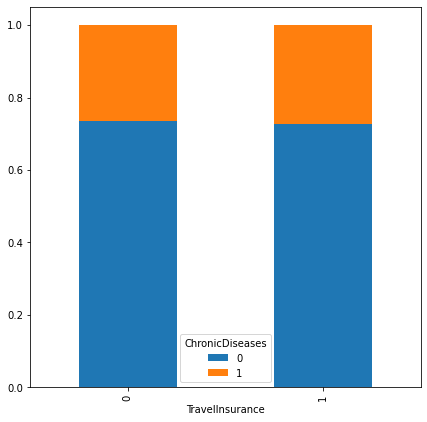

In [13]:
# ChronicDiseases
(data.groupby('TravelInsurance')['ChronicDiseases'].value_counts(normalize=True)
   .unstack('ChronicDiseases').plot.bar(stacked=True, figsize=(7,7))
)

<AxesSubplot:xlabel='TravelInsurance'>

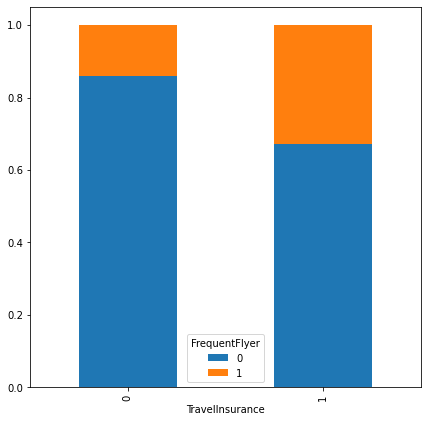

In [14]:
# FrequentFlyer
(data.groupby('TravelInsurance')['FrequentFlyer'].value_counts(normalize=True)
   .unstack('FrequentFlyer').plot.bar(stacked=True, figsize=(7,7))
)

<AxesSubplot:xlabel='TravelInsurance'>

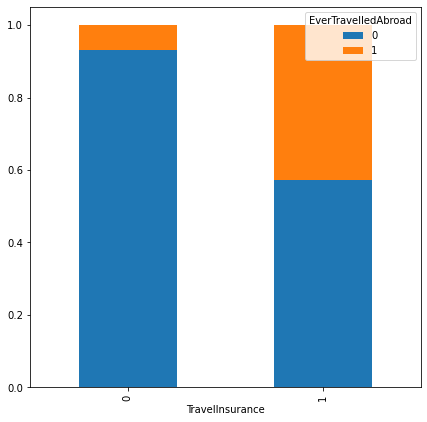

In [15]:
# EverTravelledAbroad
(data.groupby('TravelInsurance')['EverTravelledAbroad'].value_counts(normalize=True)
   .unstack('EverTravelledAbroad').plot.bar(stacked=True, figsize=(7,7))
)

## Feature preparation

In [16]:
# relevant features
relevant_features = [
    'Age',
    'Employment.Type',
    'AnnualIncome',
    'FamilyMembers',
    'FrequentFlyer',
    'EverTravelledAbroad',
    'TravelInsurance',
]

data = data[relevant_features]

In [17]:
data['Employment.Type'] = data['Employment.Type'].map({
    'Private Sector/Self Employed': 1,
    'Government Sector': 0
})

In [18]:
data.head()

,Age,Employment.Type,AnnualIncome,FamilyMembers,FrequentFlyer,EverTravelledAbroad,TravelInsurance
0,33,1,750000,7,0,0,1
1,29,1,1100000,2,0,0,0
2,31,0,1200000,3,0,0,0
3,26,1,500000,3,0,0,0
4,28,1,800000,3,0,0,0


In [19]:
# train test split
X = data.drop('TravelInsurance', axis=1)
y = data['TravelInsurance']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.2, random_state=42)

In [20]:
# scale data
scaler = MinMaxScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train))
X_train.columns = X.columns
X_test = pd.DataFrame(scaler.fit_transform(X_test))
X_train.columns = X.columns

## Model creation

In [21]:
# list with sampling methods
sampling_methods = [
    None,
    RandomOverSampler(random_state=42),
    SMOTE(random_state=42),
    BorderlineSMOTE(random_state=42),
    RandomUnderSampler(random_state=42),
    NearMiss(version=3),
    TomekLinks()
]

In [22]:
# function to calculate metrics
def calculate_metrics(y_test, y_pred):
    
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    
    return accuracy, f1, precision, recall

# function to plot confusion matrix
def plot_cf(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    
    fig, ax = plt.subplots(figsize=(5.5, 4))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt=".0f")
    ax.set_xlabel('Predicted label')
    ax.set_ylabel('Real label')
    plt.show()

In [23]:
# lists to store results
model_list = []
sampling_list = []
accuracy_list = []
f1_list = []
precision_list = []
recall_list = []

Sampling method: None
Accuracy: 0.787
F1: 0.640
Precision: 0.786
Recall: 0.539


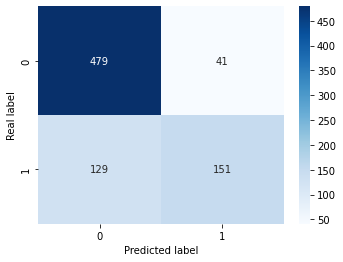

Sampling method: RandomOverSampler
Accuracy: 0.691
F1: 0.582
Precision: 0.553
Recall: 0.614


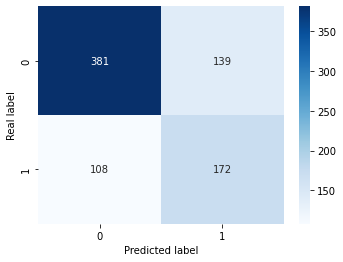

Sampling method: SMOTE
Accuracy: 0.724
F1: 0.632
Precision: 0.592
Recall: 0.679


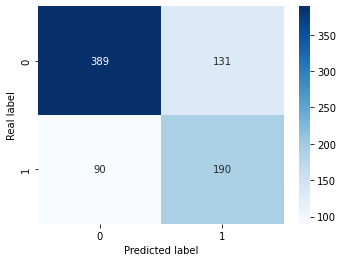

Sampling method: BorderlineSMOTE
Accuracy: 0.698
F1: 0.578
Precision: 0.565
Recall: 0.593


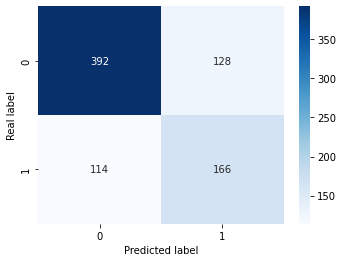

Sampling method: RandomUnderSampler
Accuracy: 0.751
F1: 0.638
Precision: 0.651
Recall: 0.625


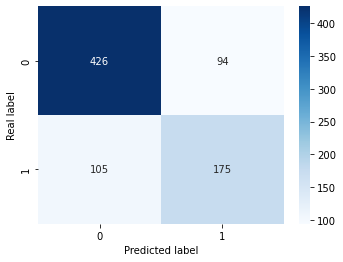

Sampling method: NearMiss
Accuracy: 0.711
F1: 0.544
Precision: 0.608
Recall: 0.493


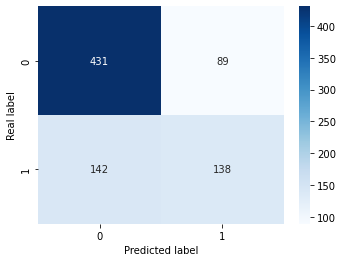

Sampling method: TomekLinks
Accuracy: 0.750
F1: 0.595
Precision: 0.687
Recall: 0.525


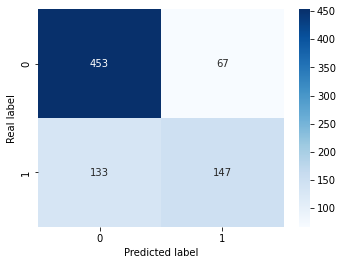

In [24]:
# KNeighborsClassifier
for sampler in sampling_methods:
    # sample
    if sampler == None:
        X_train_res, y_train_res = X_train.copy(), y_train.copy()
    else:
        X_train_res, y_train_res = sampler.fit_resample(X_train, y_train)
        
    grid_param = {
            'n_neighbors': [3, 5, 7, 10, 15],
            'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute',],
            'metric': ['cosine', 'euclidean', 'l1', 'l2', 'manhattan'],
    }
    
    # create classifier
    clf = KNeighborsClassifier()
    gs = GridSearchCV(estimator=clf, param_grid=grid_param, cv=5)
    gs.fit(X_train_res, y_train_res)
    
    # predict
    y_pred = gs.predict(X_test)
    
    accuracy, f1, precision, recall = calculate_metrics(y_test, y_pred)
    if sampler == None:
        print("Sampling method: None")
    else:
        print(f"Sampling method: {sampler.__class__.__name__}")
    
    print(f"Accuracy: {accuracy:.3f}")
    print(f"F1: {f1:.3f}")
    print(f"Precision: {precision:.3f}")
    print(f"Recall: {recall:.3f}")
    plot_cf(y_test, y_pred)
    
    # store results
    model_list.append('KNN')
    sampling_list.append(sampler.__class__.__name__)
    accuracy_list.append(accuracy)
    f1_list.append(f1)
    precision_list.append(precision)
    recall_list.append(recall)

Sampling method: None
Accuracy: 0.766
F1: 0.625
Precision: 0.712
Recall: 0.557


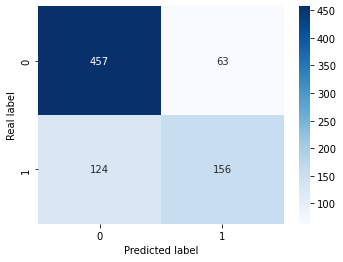

Sampling method: RandomOverSampler
Accuracy: 0.714
F1: 0.624
Precision: 0.578
Recall: 0.679


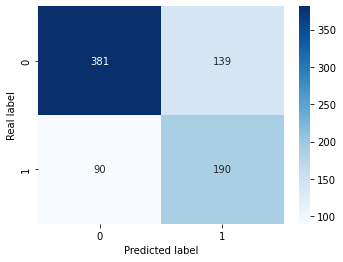

Sampling method: SMOTE
Accuracy: 0.719
F1: 0.640
Precision: 0.580
Recall: 0.714


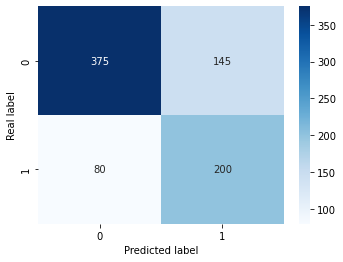

Sampling method: BorderlineSMOTE
Accuracy: 0.646
F1: 0.573
Precision: 0.496
Recall: 0.679


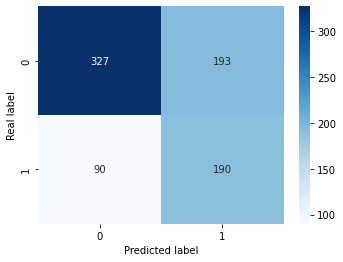

Sampling method: RandomUnderSampler
Accuracy: 0.694
F1: 0.587
Precision: 0.556
Recall: 0.621


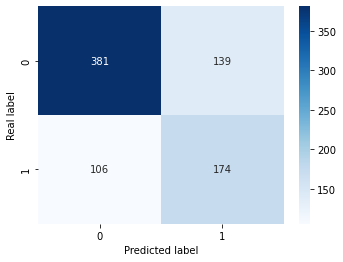

Sampling method: NearMiss
Accuracy: 0.685
F1: 0.599
Precision: 0.540
Recall: 0.671


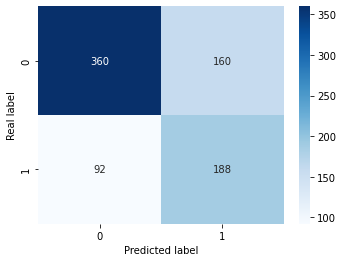

Sampling method: TomekLinks
Accuracy: 0.759
F1: 0.621
Precision: 0.690
Recall: 0.564


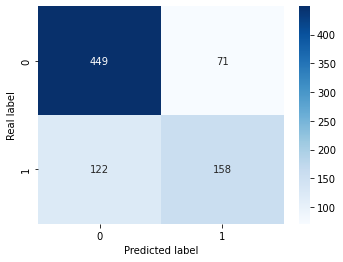

In [25]:
# LogisticRegression
for sampler in sampling_methods:
    # sample
    if sampler == None:
        X_train_res, y_train_res = X_train.copy(), y_train.copy()
    else:
        X_train_res, y_train_res = sampler.fit_resample(X_train, y_train)
        
    grid_param = {
        'fit_intercept': [True, False,],
        'solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],
        'C': [10, 1, 0.1, 0.01,]
    }
    
    # create classifier
    clf = LogisticRegression()
    gs = GridSearchCV(estimator=clf, param_grid=grid_param, cv=5)
    gs.fit(X_train_res, y_train_res)
    
    # predict
    y_pred = gs.predict(X_test)
    
    accuracy, f1, precision, recall = calculate_metrics(y_test, y_pred)
    if sampler == None:
        print("Sampling method: None")
    else:
        print(f"Sampling method: {sampler.__class__.__name__}")
    
    print(f"Accuracy: {accuracy:.3f}")
    print(f"F1: {f1:.3f}")
    print(f"Precision: {precision:.3f}")
    print(f"Recall: {recall:.3f}")
    plot_cf(y_test, y_pred)
    
    # store results
    model_list.append('LR')
    sampling_list.append(sampler.__class__.__name__)
    accuracy_list.append(accuracy)
    f1_list.append(f1)
    precision_list.append(precision)
    recall_list.append(recall)

Sampling method: None
Accuracy: 0.761
F1: 0.626
Precision: 0.693
Recall: 0.571


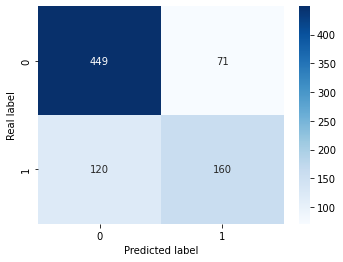

Sampling method: RandomOverSampler
Accuracy: 0.741
F1: 0.635
Precision: 0.627
Recall: 0.643


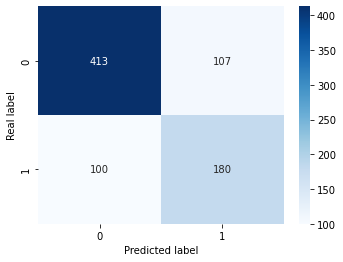

Sampling method: SMOTE
Accuracy: 0.738
F1: 0.629
Precision: 0.622
Recall: 0.636


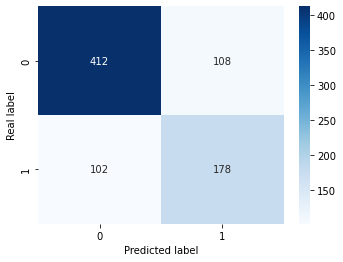

Sampling method: BorderlineSMOTE
Accuracy: 0.719
F1: 0.629
Precision: 0.584
Recall: 0.682


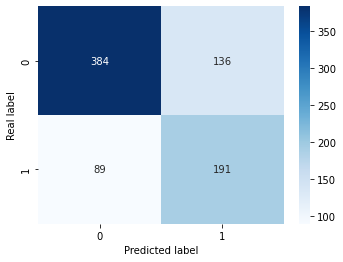

Sampling method: RandomUnderSampler
Accuracy: 0.714
F1: 0.609
Precision: 0.584
Recall: 0.636


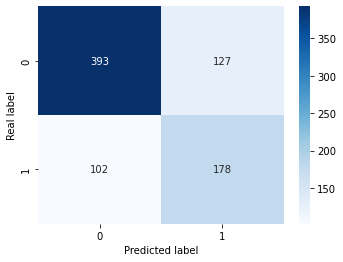

Sampling method: NearMiss
Accuracy: 0.739
F1: 0.642
Precision: 0.617
Recall: 0.668


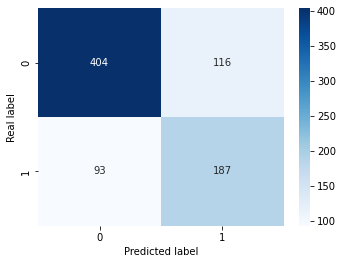

Sampling method: TomekLinks
Accuracy: 0.752
F1: 0.619
Precision: 0.671
Recall: 0.575


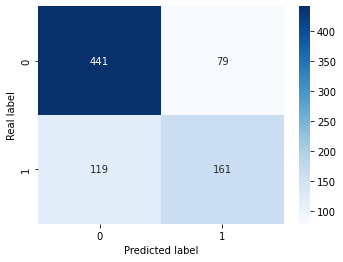

In [26]:
# QuadraticDiscriminantAnalysis
for sampler in sampling_methods:
    # sample
    if sampler == None:
        X_train_res, y_train_res = X_train.copy(), y_train.copy()
    else:
        X_train_res, y_train_res = sampler.fit_resample(X_train, y_train)
        
    grid_param = {
        'tol': [0.1, 0.01, 0.001, 0.0001, 0.00001],
    }
    
    # create classifier
    clf = QuadraticDiscriminantAnalysis()
    gs = GridSearchCV(estimator=clf, param_grid=grid_param, cv=5)
    gs.fit(X_train_res, y_train_res)
    
    # predict
    y_pred = gs.predict(X_test)
    
    accuracy, f1, precision, recall = calculate_metrics(y_test, y_pred)
    if sampler == None:
        print("Sampling method: None")
    else:
        print(f"Sampling method: {sampler.__class__.__name__}")
    
    print(f"Accuracy: {accuracy:.3f}")
    print(f"F1: {f1:.3f}")
    print(f"Precision: {precision:.3f}")
    print(f"Recall: {recall:.3f}")
    plot_cf(y_test, y_pred)
    
    # store results
    model_list.append('QDA')
    sampling_list.append(sampler.__class__.__name__)
    accuracy_list.append(accuracy)
    f1_list.append(f1)
    precision_list.append(precision)
    recall_list.append(recall)

In [27]:
results = pd.DataFrame({
    'Model': model_list,
    'Sampling': sampling_list,
    'Accuracy': accuracy_list,
    'F1': f1_list,
    'Precision': precision_list,
    'Recall_list': recall_list,
})

results

,Model,Sampling,Accuracy,F1,Precision,Recall_list
0,KNN,NoneType,0.787,0.640,0.786,0.539
1,KNN,RandomOverSampler,0.691,0.582,0.553,0.614
2,KNN,SMOTE,0.724,0.632,0.592,0.679
3,KNN,BorderlineSMOTE,0.698,0.578,0.565,0.593
4,KNN,RandomUnderSampler,0.751,0.638,0.651,0.625
5,KNN,NearMiss,0.711,0.544,0.608,0.493
6,KNN,TomekLinks,0.750,0.595,0.687,0.525
7,LR,NoneType,0.766,0.625,0.712,0.557
8,LR,RandomOverSampler,0.714,0.624,0.578,0.679
9,LR,SMOTE,0.719,0.640,0.580,0.714
